In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import pandas as pd
import pickle
import statistics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
import numpy as np
# import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2, venn2_circles

In [3]:
# now I will build the finalDataFrame
# but this time I will call it finalDataFrameWithoutDemographic

In [3]:
# loading the dataset which has the features (gene symbol)
file_path = 'dataset/ADNI_Gene_Expression_Profile.csv'
df1 = pd.read_csv(file_path)

In [4]:
# loading the dataset with targets (phenotype) and demographic (age, gender, ethnicity, race)
file_path = 'dataset/Complete_ADNI_clinical_info.csv'
df2 = pd.read_csv(file_path)

In [5]:
col = df1.columns[3:747]
# print(len(c))
sampleList = []
for c in col:
    sample = df1.loc[:, c]
    sample = sample.tolist()
    sampleList.append(sample)

tem_col = list(df1['Unnamed: 2'])
tem_col[1] = 'IID'

In [6]:
# final step of making the finalDataFrameWithoutDemographic
finalDataFrameWithoutDemographic = pd.DataFrame(sampleList, columns=tem_col)
finalDataFrameWithoutDemographic = finalDataFrameWithoutDemographic.loc[:, finalDataFrameWithoutDemographic.columns.notna()]
finalDataFrameWithoutDemographic = finalDataFrameWithoutDemographic.drop(columns=['Symbol'])

finalDataFrameWithoutDemographic['Phenotype'] = ""

for index, row in finalDataFrameWithoutDemographic.iterrows():
    patientID = finalDataFrameWithoutDemographic.at[index, 'IID']
    # cell_value = df.at[row_number, column_name]
    #print("P ID: ", patient)
    for index2, row2 in df2.iterrows():
        if df2.at[index2, 'IID'] == patientID:
            finalDataFrameWithoutDemographic.at[index, 'Phenotype'] = df2.at[index2, 'Phenotype']

In [8]:
# finalDataFrameWithoutDemographic.head()

In [7]:
# final step of making the finalDataFrameWithDemographic

finalDataFrameWithDemographic = pd.DataFrame(sampleList, columns=tem_col)
finalDataFrameWithDemographic = finalDataFrameWithDemographic.loc[:, finalDataFrameWithDemographic.columns.notna()]
finalDataFrameWithDemographic = finalDataFrameWithDemographic.drop(columns=['Symbol'])

finalDataFrameWithDemographic['Age'] = ""
finalDataFrameWithDemographic['Gender'] = ""
finalDataFrameWithDemographic['Ethnicity'] = ""
finalDataFrameWithDemographic['Race'] = ""
finalDataFrameWithDemographic['Phenotype'] = ""

for index, row in finalDataFrameWithoutDemographic.iterrows():
    patientID = finalDataFrameWithoutDemographic.at[index, 'IID']
    # cell_value = df.at[row_number, column_name]
    #print("P ID: ", patient)
    for index2, row2 in df2.iterrows():
        if df2.at[index2, 'IID'] == patientID:
            finalDataFrameWithDemographic.at[index, 'Age'] = df2.at[index2, 'Age']
            finalDataFrameWithDemographic.at[index, 'Gender'] = df2.at[index2, 'Gender']
            finalDataFrameWithDemographic.at[index, 'Ethnicity'] = df2.at[index2, 'Ethnicity']
            finalDataFrameWithDemographic.at[index, 'Race'] = df2.at[index2, 'Race']
            finalDataFrameWithDemographic.at[index, 'Phenotype'] = df2.at[index2, 'Phenotype']

In [11]:
# finalDataFrameWithDemographic.head()

In [35]:
# now I will preprocess the finalDataFrame both with and without Demographic

In [8]:
pickle_file_name = 'keyDictionaryPickel.pickle'
with open(pickle_file_name, 'rb') as file:
    keyDictionary = pickle.load(file)

In [37]:
# now I will preporcess finalDataFrameWithoutDemographic

In [9]:
columnsWithoutDemographic =  set(finalDataFrameWithoutDemographic.columns)
idxsWithoutDemographic = finalDataFrameWithoutDemographic["IID"]

In [10]:
dic = defaultdict(list)
for idx in idxsWithoutDemographic:
    for col in columnsWithoutDemographic:
        res = keyDictionary.get((idx, col))
        if res:
            dic[col].append(np.mean(res))
lastWithoutDemographic = pd.DataFrame(dic)

In [16]:
# lastWithoutDemographic

In [11]:
originalColWithoutDemographic = finalDataFrameWithoutDemographic.columns
newColWithoutDemographic = lastWithoutDemographic.columns
disjointColWithoutDemographic = [i for i in originalColWithoutDemographic if i not in newColWithoutDemographic]
lastWithoutDemographic = lastWithoutDemographic.merge(finalDataFrameWithoutDemographic[disjointColWithoutDemographic], left_index=True, right_index=True)

In [48]:
# lastWithoutDemographic

In [12]:
# there are 16 sample such that for that 16 samples phenotype is "". I will drop those samples/rows

lastWithoutDemographic.replace("", np.nan, inplace=True)
print(sum(lastWithoutDemographic.isna().sum()))
lastWithoutDemographic = lastWithoutDemographic[lastWithoutDemographic["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastWithoutDemographic.isna().sum()))

16
0


In [13]:
for col in lastWithoutDemographic.columns:
    if (
        any(lastWithoutDemographic[col].isna())
        and lastWithoutDemographic[col].isna().value_counts().to_dict().get(True) / len(lastWithoutDemographic[col])
        > 0.90
    ):
        print(col)
        lastWithoutDemographic = lastWithoutDemographic.drop(col, axis=1)

In [14]:
lastWithoutDemographic.head()

,ZNF425,COL4A1,RBL1,ARG2,EIF3CL || EIF3C,DDX17,SKIDA1,NUP210,MRPS28,DSCC1,...,ENSG00000233920,ENSG00000226276,ENSG00000228033,IFITM10,ND4,ENSG00000226406,ENSG00000255209,RPS10,RNA28S5 || RNA45S5,Phenotype
0,2.5245,2.193333,3.054333,5.6575,7.4938,8.841333,2.29850,6.5660,5.1690,2.505000,...,2.800,2.681,1.944,3.513,11.901,3.186,2.235,11.932,4.416,2.0
1,2.5675,2.246667,3.295667,5.7840,7.1532,8.878000,2.31225,6.8125,5.6555,2.444000,...,3.196,4.888,1.924,3.058,11.695,2.883,2.435,12.202,4.746,0.0
2,2.7175,2.073000,3.227333,5.5900,7.2202,9.072000,2.33050,7.1500,5.3050,2.768000,...,3.401,3.120,1.853,3.907,12.042,3.535,2.356,12.148,5.519,2.0
3,2.6625,2.138667,3.184000,5.7615,7.4932,9.478333,2.32825,7.0510,4.5075,2.251333,...,3.260,3.177,2.104,4.007,12.182,3.507,2.005,11.871,5.281,0.0
4,2.7965,2.079667,3.121667,5.7055,7.1698,8.898000,2.21300,6.5210,4.8670,2.113000,...,3.000,3.401,2.091,3.517,11.856,2.780,2.138,12.072,4.514,1.0


In [22]:
# # first I will save this preprocessed dataset to a csv file
# file_path = 'preprocessed dataset/last_without_demographic.csv'

# # Save the DataFrame to a CSV file
# lastWithoutDemographic.to_csv(file_path, index=False)

In [56]:
# preprocessing done for the dataframe without demographic
# now I will train lasso and extract the important features from this dataframe

In [15]:
featuresWithoutDemographic = lastWithoutDemographic.drop('Phenotype', axis = 1)
targetWithoutDemographic = lastWithoutDemographic['Phenotype']

In [16]:
featuresWithoutDemographic = featuresWithoutDemographic.drop('IID', axis = 1)

In [17]:
lasso1 = Lasso(alpha=0.01)
lasso1.fit(featuresWithoutDemographic, targetWithoutDemographic)
selectedFeaturesWithoutDemographic = featuresWithoutDemographic.columns[lasso1.coef_ != 0.0]

In [23]:
pd.DataFrame(selectedFeaturesWithoutDemographic, columns = ['Gene']).to_csv('selectedFeaturesWithoutDemographic.csv')

In [19]:
type(selectedFeaturesWithoutDemographic)

pandas.core.indexes.base.Index

In [10]:
columnsWithDemographic =  set(finalDataFrameWithDemographic.columns)
idxsWithDemographic = finalDataFrameWithDemographic["IID"]

In [11]:
dic2 = defaultdict(list)
for idx in idxsWithDemographic:
    for col in columnsWithDemographic:
        res = keyDictionary.get((idx, col))
        if res:
            dic2[col].append(np.mean(res))
lastWithDemographic = pd.DataFrame(dic2)

In [30]:
# lastWithDemographic

In [26]:
originalColWithDemographic = finalDataFrameWithDemographic.columns
newColWithDemographic = lastWithDemographic.columns
disjointColWithDemographic = [i for i in originalColWithDemographic if i not in newColWithDemographic]
lastWithDemographic = lastWithDemographic.merge(finalDataFrameWithDemographic[disjointColWithDemographic], left_index=True, right_index=True)

In [44]:
# lastWithDemographic

In [27]:
# there are 16 sample such that for that 16 samples phenotype is "". I will drop those samples/rows

lastWithDemographic.replace("", np.nan, inplace=True)
print(sum(lastWithDemographic.isna().sum()))
lastWithDemographic = lastWithDemographic[lastWithDemographic["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastWithDemographic.isna().sum()))

80
0


In [28]:
for col in lastWithDemographic.columns:
    if (
        any(lastWithDemographic[col].isna())
        and lastWithDemographic[col].isna().value_counts().to_dict().get(True) / len(lastWithDemographic[col])
        > 0.90
    ):
        print(col)
        lastWithDemographic = lastWithDemographic.drop(col, axis=1)

In [53]:
print(min(lastWithDemographic['Age']))
print(max(lastWithDemographic['Age']))

55.6
96.9


In [54]:
# as the limit of the age feature is not that big (97-56=41) 
# I have decided not to normalize this feature
# in addition, lasso isn't that sensitive to the scale of features

In [29]:
featuresWithDemographic = lastWithDemographic.drop('Phenotype', axis = 1)
targetWithDemographic = lastWithDemographic['Phenotype']

In [30]:
featuresWithDemographic = featuresWithDemographic.drop('IID', axis = 1)

In [31]:
lasso2 = Lasso(alpha=0.01)
lasso2.fit(featuresWithDemographic, targetWithDemographic)
selectedFeaturesWithDemographic = featuresWithDemographic.columns[lasso2.coef_ != 0.0]

In [32]:
len(selectedFeaturesWithDemographic)

310

In [33]:
pd.DataFrame(selectedFeaturesWithDemographic, columns = ['Gene']).to_csv('selectedFeaturesWithDemographic.csv')

In [34]:
selectedFeaturesWithoutDemographicList = selectedFeaturesWithoutDemographic.tolist()
selectedFeaturesWithDemographicList = selectedFeaturesWithDemographic.tolist()

In [35]:
print(len(selectedFeaturesWithoutDemographicList))
print(len(selectedFeaturesWithDemographicList))

299
310


In [73]:
# now I will represent this two set of selected features by Venn Diagram

In [36]:
selectedFeaturesInBoth = []
for feature in selectedFeaturesWithoutDemographicList:
    if feature in selectedFeaturesWithDemographicList:
        selectedFeaturesInBoth.append(feature)

In [39]:
# print(selectedFeaturesInBoth)

In [40]:
csv_file = "selectedFeaturesInBoth.csv"

# Open the CSV file in write mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the strings to the CSV file, one per row in the first column
    for string in selectedFeaturesInBoth:
        writer.writerow([string])

In [76]:
inBothList = 0

for feature in selectedFeaturesWithoutDemographicList:
    if feature in selectedFeaturesWithDemographicList:
        inBothList += 1
        
onlyInFirstList = len(selectedFeaturesWithoutDemographicList) - inBothList
onlyInSecondList = len(selectedFeaturesWithDemographicList) - inBothList

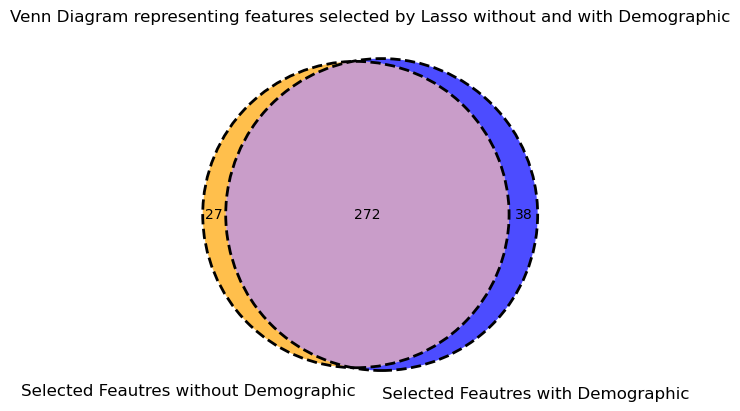

In [88]:
# depict venn diagram 
venn2(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
      set_labels=('Selected Feautres without Demographic', 'Selected Feautres with Demographic'), 
      set_colors=("orange", "blue"), alpha=.7) 
  
# add outline 
venn2_circles(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
              linestyle="dashed",  
              linewidth=2) 
  

# assign title of the venn diagram 
plt.title("Venn Diagram representing features selected by Lasso without and with Demographic")   
plt.show()